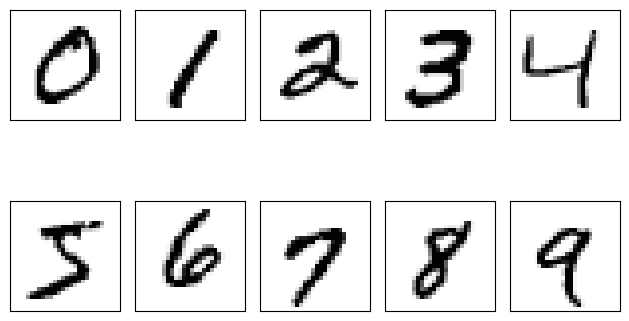

(100, 784)
(100,)
Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 76.15% | Valid Acc: 75.98%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 85.45% | Valid Acc: 85.04%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 87.82% | Valid Acc: 87.60%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 89.36% | Valid Acc: 89.28%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.21% | Valid Acc: 90.04%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.67% | Valid Acc: 90.54%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.12% | Valid Acc: 90.82%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.43% | Valid Acc: 91.26%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 91.84% | Valid Acc: 91.50%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.04% | Valid Acc: 91.84%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.30% | Valid Acc: 92.08%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.51% | Valid Acc: 92.24%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.65% | Valid Acc: 92.30%
Epoch: 014/050 | Train MSE: 0.01 

In [100]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

X = ((X / 255.0) - 0.5) * 2

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000,
    random_state=123, stratify=y_temp
)

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary


class NeuralNetMLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        self.num_classes = num_classes
        rng = np.random.RandomState(random_seed)
        self.w_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features)
        )
        self.b_h = np.zeros(num_hidden)
        self.w_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden)
        )
        self.b_out = np.zeros(num_classes)

    def forward(self, x):
        z_h = np.dot(x, self.w_h.T) + self.b_h
        a_h = sigmoid(z_h)
        z_out = np.dot(a_h, self.w_out.T) + self.b_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):
        y_onehot = int_to_onehot(y, self.num_classes)

        d_loss = 2. * (a_out - y_onehot) / y.shape[0]
        sig_deriv_out = a_out * (1. - a_out)
        delta_out = d_loss * sig_deriv_out

        grad_w_out = np.dot(delta_out.T, a_h)
        grad_b_out = np.sum(delta_out, axis=0)

        sig_deriv_h = a_h * (1. - a_h)
        delta_h = np.dot(delta_out, self.w_out) * sig_deriv_h

        grad_w_h = np.dot(delta_h.T, x)
        grad_b_h = np.sum(delta_h, axis=0)

        return grad_w_out, grad_b_out, grad_w_h, grad_b_h

model = NeuralNetMLP(num_features=28 * 28, num_hidden=50, num_classes=10)

num_epochs = 50
minibatch_size = 100

def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

for i in range(num_epochs):
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size
    )
    for X_train_mini, y_train_mini in minibatch_gen:
        break
    break

print(X_train_mini.shape)
print(y_train_mini.shape)

def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(
        targets, num_labels=num_labels
    )
    return np.mean((onehot_targets - probas) ** 2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

def compute_mse_and_acc(model, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):
        _, probas = model.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = int_to_onehot(
            targets, num_labels=num_labels
        )
        loss = np.mean((onehot_targets - probas) ** 2)
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss

    mse = mse / (i + 1)
    acc = correct_pred / num_examples
    return mse, acc

def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size
        )

        for X_train_mini, y_train_mini in minibatch_gen:

            a_h, a_out = model.forward(X_train_mini)

            grads = model.backward(X_train_mini, a_h, a_out,
                                   y_train_mini)

            model.w_out -= learning_rate * grads[0]
            model.b_out -= learning_rate * grads[1]
            model.w_h -= learning_rate * grads[2]
            model.b_h -= learning_rate * grads[3]

        train_mse, train_acc = compute_mse_and_acc(
            model, X_train, y_train
        )
        valid_mse, valid_acc = compute_mse_and_acc(
            model, X_valid, y_valid
        )
        train_acc, valid_acc = train_acc * 100, valid_acc * 100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e + 1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

np.random.seed(123)
epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1
)

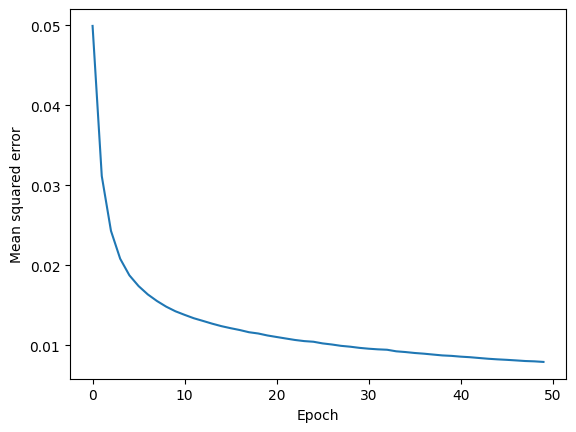

In [101]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

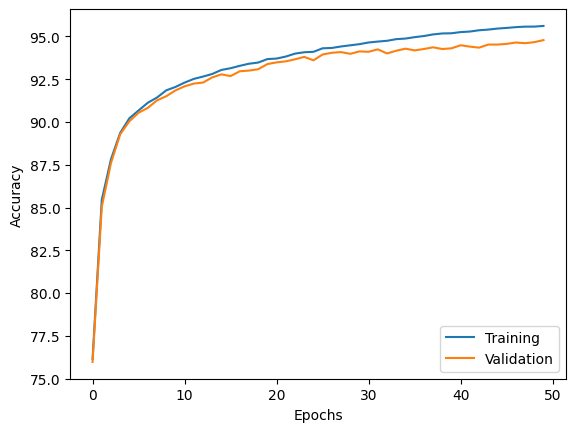

In [102]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()